In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC  
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.mixture import GaussianMixture
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn import ensemble
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.dummy import DummyClassifier
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay

In [3]:
#intervening fit
i_c = pd.read_csv("intervening_final_busyfit.txt", sep='\t')
#intervening fit without nan or inf or -inf
i_c_2 = i_c.replace([np.inf, -np.inf], np.nan).dropna(axis=0)

#getting all the file names which have nan or inf or -inf
all_i = i_c.merge(i_c_2.drop_duplicates(), on = ['Filename'], how='left', indicator=True)
intervening_non_fit = all_i[all_i['_merge'] == 'left_only']
# for i in intervening_non_fit['Filename'].tolist():
#     print(i)

#associated fit
a_c = pd.read_csv("associated_final_busyfit.txt", sep='\t')
#associated fit without nan or inf or -inf
a_c_2 = a_c.replace([np.inf, -np.inf], np.nan).dropna(axis=0)

all_a = a_c.merge(a_c_2.drop_duplicates(), on = ['Filename'], how='left', indicator=True)
associated_non_fit_c = all_a[all_a['_merge'] == 'left_only']
# for i in associated_non_fit_c['Filename'].tolist():
#     print(i)

#maccagni fit
a_m = pd.read_csv("associated_maccagni_busyfit.txt", sep='\t')
a_m_2 = a_m.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
all_a_m = a_m.merge(a_m_2.drop_duplicates(), on = ['Filename'], how='left', indicator=True)
associated_non_fit_m = all_a_m[all_a_m['_merge'] == 'left_only']
# for i in associated_non_fit_m['Filename'].tolist():
#     print(i)

#adding coloumn int or ass to all fits
i_c_2['Class'] = '1'

a_m_2['Class'] = '0'
a_c_2['Class'] = '0'

i_c_2.reset_index(drop=True, inplace=True)
a_m_2.reset_index(drop=True, inplace=True)
a_c_2.reset_index(drop=True, inplace=True)

tot_fit = pd.concat([a_m_2, a_c_2, i_c_2])
tot_fit

,Filename,Success,Nchan,dof,chi^2,chi^2/dof,rms,A,dA,B_1,...,dX,W_50,dW_50,W_20,dW_20,F_peak,dF_peak,F_int,dF_int,Class
0,J075756.71+395936.1_spec.txt,0,220,215,0.241625,1.123840e-03,0.01,6.551380e-03,2.348060e-01,0.340817,...,9.008650e+05,662044.000000,1.660410e+06,1.062960e+06,1.898960e+06,0.003374,5.540310e-03,2.445330e+03,3.875260e+03,0
1,J080601.51+190614.7_spec.txt,1,220,215,0.791508,3.681430e-03,0.01,1.611550e+08,1.317940e+12,0.194234,...,2.516540e+07,946240.000000,3.469110e+07,1.572540e+06,4.018270e+07,0.004742,2.758470e-01,5.141530e+03,7.666010e+04,0
2,J080938.88+345537.2_spec.txt,0,179,174,0.208775,1.199860e-03,0.01,1.220950e-03,1.069010e-02,0.666952,...,8.594470e+05,336005.000000,2.290560e+06,4.409460e+05,2.413040e+06,0.001213,8.751560e-03,4.089210e+02,2.149430e+03,0
3,J082133.60+470237.3_spec.txt,0,220,215,5.466280,2.542460e-02,0.01,1.216850e-02,1.186100e-01,4.932720,...,5.326000e+12,156281.000000,5.489940e+12,1.788810e+05,2.287100e+13,0.012169,1.000230e-02,1.901090e+03,9.339690e+10,0
4,J083548.14+151717.0_spec.txt,0,220,212,6.723680,3.171550e-02,0.01,3.962510e-03,6.849950e-02,0.543345,...,6.528260e+06,79326.700000,4.652750e+06,2.990630e+05,1.629490e+07,0.009235,1.008340e+00,1.753190e+03,6.873300e+04,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17,SPEC_J1438d.DAT,0,505,500,0.000014,2.824970e-08,0.01,1.323280e-05,1.296320e-02,0.237052,...,1.611450e+01,0.076026,4.065540e+01,1.074030e-01,4.347480e+01,0.000013,5.776920e-03,9.724450e-07,3.588860e-04,1
18,SPEC_J1443.DAT,1,512,507,0.000006,1.106880e-08,0.01,5.765260e+05,1.458590e+12,0.083403,...,3.112360e+01,0.030672,9.952680e+01,4.841710e-02,5.708230e+01,0.000046,1.457160e-02,1.568460e-06,1.743000e-03,1
19,SPEC_J1551.DAT,0,505,500,0.000008,1.623710e-08,0.01,1.363980e-05,6.778090e-01,10.147900,...,3.793980e+15,0.010128,4.768150e+16,1.823070e-02,3.307710e+16,0.000009,4.118540e+13,1.007240e-07,6.106090e+10,1
20,SPEC_J1639.DAT,0,512,504,0.000180,3.577950e-07,0.01,1.124310e-04,3.582340e-01,0.126561,...,2.170810e+00,0.104726,5.115290e+00,1.432350e-01,5.778230e+00,0.000078,4.274530e-03,8.203460e-06,2.992320e-04,1


In [14]:
tot_fit.columns

Index(['Filename', 'Success', 'Nchan', 'dof', 'chi^2', 'chi^2/dof', 'rms', 'A',
       'dA', 'B_1', 'dB_1', 'B_2', 'dB_2', 'C', 'dC', 'XE_0', 'dXE_0', 'XP_0',
       'dXP_0', 'W', 'dW', 'N', 'dN', 'X', 'dX', 'W_50', 'dW_50', 'W_20',
       'dW_20', 'F_peak', 'dF_peak', 'F_int', 'dF_int', 'Class'],
      dtype='object')

In [15]:
# input
X = tot_fit.iloc[:, [7, 9, 11, 13, 15, 17, 21, 29, 31]].values #excluding 19, 23, 25, 27 columns
# output
y = tot_fit.iloc[:, 33].values.astype('int')

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)

In [16]:
table = tot_fit.iloc[:, [0, 7, 9, 11, 13, 15, 17, 21, 29, 31, 33]]
table.to_csv('busyfit_table.csv')

In [17]:
# checking the scores for zero rule model

score_list = ['roc_auc', 'accuracy', 'average_precision']
for i in score_list:
    print('{} for Zero Rule Model is {}'.format(i, np.mean(cross_val_score(DummyClassifier(strategy='prior'), X, y, scoring=i, cv=cv, n_jobs=-1))))

roc_auc for Zero Rule Model is 0.5
accuracy for Zero Rule Model is 0.7872727272727275
average_precision for Zero Rule Model is 0.21272727272727276


# Using SMOTE

Random Forrest

In [7]:
model_no_SMOTE = RandomForestClassifier(n_estimators=7, random_state=0)
for i in score_list:
    print('{} for without SMOTE Model is {}'.format(i, np.mean(cross_val_score(model_no_SMOTE, X, y, scoring=i, cv=cv, n_jobs=-1))))

roc_auc for without SMOTE Model is 0.9295138888888889
accuracy for without SMOTE Model is 0.9087878787878786
average_precision for without SMOTE Model is 0.8310185185185184


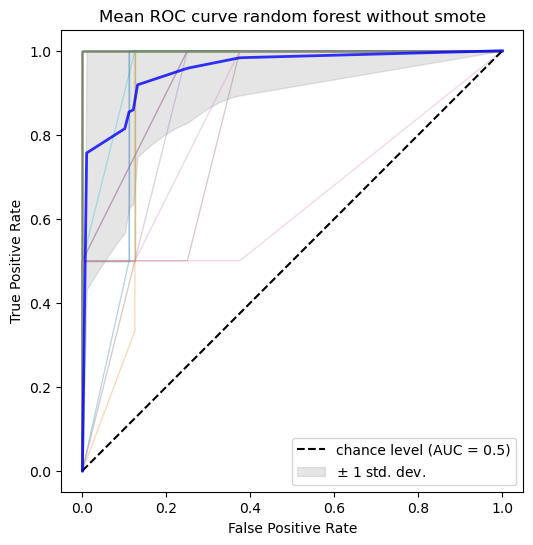

In [8]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

classifier = model_no_SMOTE

fig, ax = plt.subplots(figsize=(6, 6))
for fold, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X[train], y[train])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        X[test],
        y[test],
        #name=f"ROC fold {fold}",
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    #label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve random forest without smote",
)
ax.axis("square")
ax.legend(loc="lower right")

plt.gcf()
handles, labels = plt.gca().get_legend_handles_labels()
handles = handles[30:]
labels = labels[30:]
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.savefig('ROC_curve_random_forest_no_smote.png')
plt.show()

In [29]:
steps = [('over', SMOTE(sampling_strategy=0.9, random_state=0)), ('model', RandomForestClassifier(n_estimators=9, random_state=0))]
pipeline = Pipeline(steps=steps)
for i in score_list:
    print('{} for SMOTE Model is {}'.format(i, np.mean(cross_val_score(pipeline, X, y, scoring=i, cv=cv, n_jobs=-1))))

roc_auc for SMOTE Model is 0.9125
accuracy for SMOTE Model is 0.8678787878787878
average_precision for SMOTE Model is 0.8185858585858585


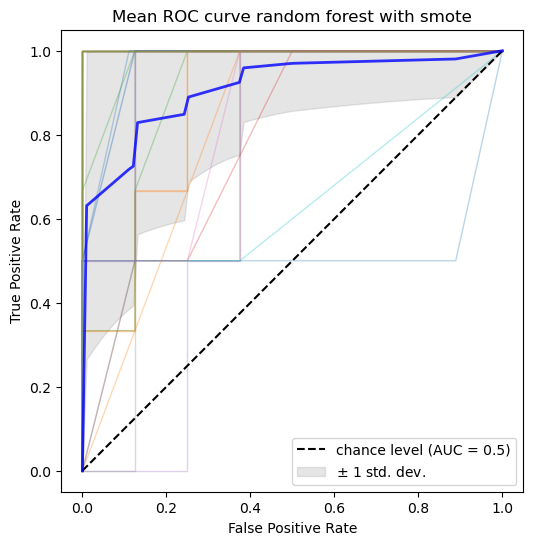

In [30]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

classifier = pipeline

fig, ax = plt.subplots(figsize=(6, 6))
for fold, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X[train], y[train])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        X[test],
        y[test],
        #name=f"ROC fold {fold}",
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    #label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve random forest with smote",
)
ax.axis("square")
ax.legend(loc="lower right")

plt.gcf()
handles, labels = plt.gca().get_legend_handles_labels()
handles = handles[30:]
labels = labels[30:]
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.savefig('ROC_curve_random_forest_smote.png')
plt.show()

KNN for SMOTE

In [62]:
steps = [('scaler', StandardScaler()), ('over', SMOTE(sampling_strategy=0.9, random_state=0)), ('model', KNeighborsClassifier(n_neighbors=15))]
pipeline = Pipeline(steps=steps)
for i in score_list:
    print('{} for KNN SMOTE Model is {}'.format(i, np.mean(cross_val_score(pipeline, X, y, scoring=i, cv=cv, n_jobs=-1))))

roc_auc for KNN SMOTE Model is 0.7203703703703703
accuracy for KNN SMOTE Model is 0.7899999999999998
average_precision for KNN SMOTE Model is 0.6062942921276254


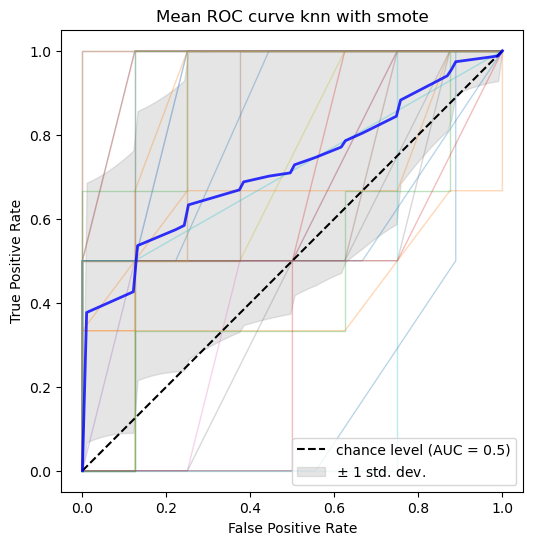

In [63]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

classifier = pipeline

fig, ax = plt.subplots(figsize=(6, 6))
for fold, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X[train], y[train])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        X[test],
        y[test],
        #name=f"ROC fold {fold}",
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    #label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve knn with smote",
)
ax.axis("square")
ax.legend(loc="lower right")

plt.gcf()
handles, labels = plt.gca().get_legend_handles_labels()
handles = handles[30:]
labels = labels[30:]
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.savefig('ROC_curve_knn_smote.png')
plt.show()

Decision tree

In [64]:
steps = [('over', SMOTE(sampling_strategy=0.9, random_state=0)), ('model', DecisionTreeClassifier(random_state=0))]
pipeline = Pipeline(steps=steps)
for i in score_list:
    print('{} for DT SMOTE Model is {}'.format(i, np.mean(cross_val_score(pipeline, X, y, scoring=i, cv=cv, n_jobs=-1))))

roc_auc for DT SMOTE Model is 0.7993055555555555
accuracy for DT SMOTE Model is 0.842121212121212
average_precision for DT SMOTE Model is 0.5660016835016837


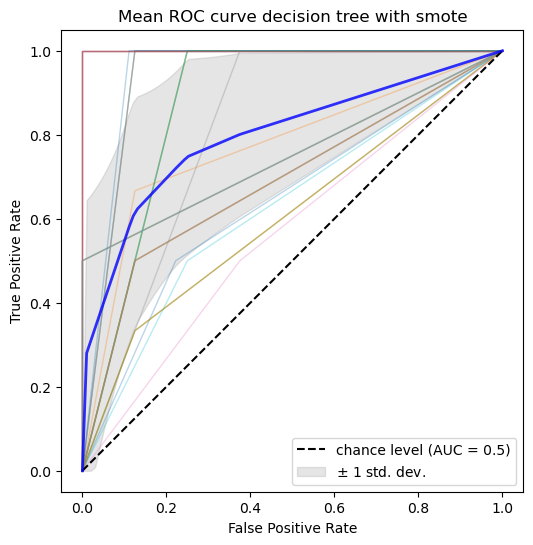

In [65]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

classifier = pipeline

fig, ax = plt.subplots(figsize=(6, 6))
for fold, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X[train], y[train])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        X[test],
        y[test],
        #name=f"ROC fold {fold}",
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    #label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve decision tree with smote",
)
ax.axis("square")
ax.legend(loc="lower right")

plt.gcf()
handles, labels = plt.gca().get_legend_handles_labels()
handles = handles[30:]
labels = labels[30:]
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.savefig('ROC_curve_decision_tree_smote.png')
plt.show()

Logistic Regression

In [66]:
steps = [('scaler', StandardScaler()), ('over', SMOTE(sampling_strategy=0.9, random_state=0)), ('model', LogisticRegressionCV(max_iter=100, random_state=0, solver='liblinear'))]
pipeline = Pipeline(steps=steps)
for i in score_list:
    print('{} for LR SMOTE Model is {}'.format(i, np.mean(cross_val_score(pipeline, X, y, scoring=i, cv=cv, n_jobs=-1))))

roc_auc for LR SMOTE Model is 0.7819444444444444
accuracy for LR SMOTE Model is 0.8518181818181818
average_precision for LR SMOTE Model is 0.7298106060606061


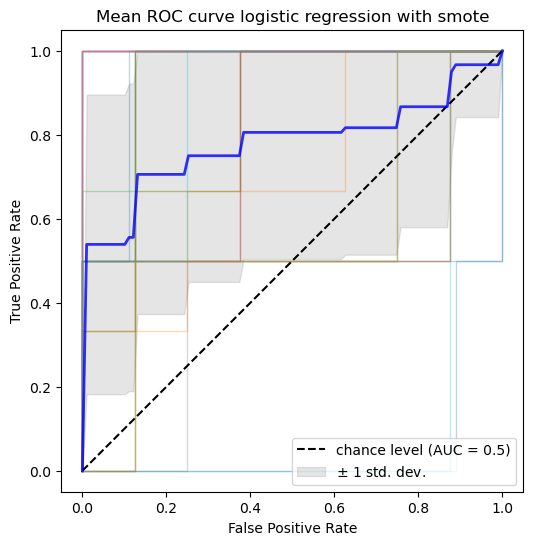

In [67]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

classifier = pipeline

fig, ax = plt.subplots(figsize=(6, 6))
for fold, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X[train], y[train])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        X[test],
        y[test],
        #name=f"ROC fold {fold}",
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    #label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve logistic regression with smote",
)
ax.axis("square")
ax.legend(loc="lower right")

plt.gcf()
handles, labels = plt.gca().get_legend_handles_labels()
handles = handles[30:]
labels = labels[30:]
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.savefig('ROC_curve_logistic_regression_smote.png')
plt.show()

In [75]:
steps = [('scaler', StandardScaler()), ('over', SMOTE(sampling_strategy=0.9, random_state=0)), ('model', SVC(kernel='linear', random_state=0))]
pipeline = Pipeline(steps=steps)
for i in score_list:
    print('{} for SVM SMOTE Model is {}'.format(i, np.mean(cross_val_score(pipeline, X, y, scoring=i, cv=cv, n_jobs=-1))))

roc_auc for SVM SMOTE Model is 0.6983796296296296
accuracy for SVM SMOTE Model is 0.8415151515151515
average_precision for SVM SMOTE Model is 0.6458291245791247


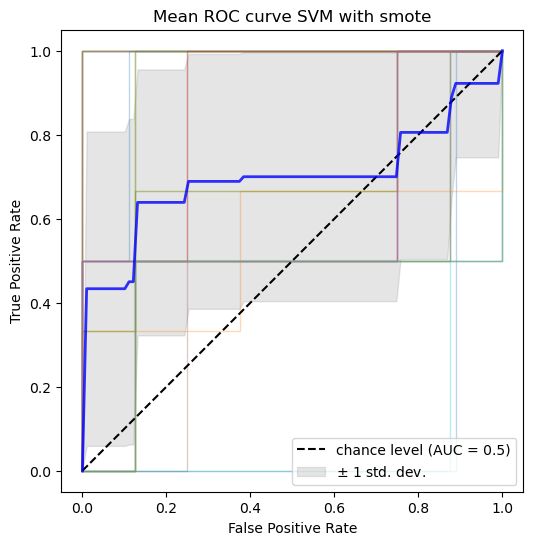

In [76]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

classifier = pipeline

fig, ax = plt.subplots(figsize=(6, 6))
for fold, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X[train], y[train])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        X[test],
        y[test],
        #name=f"ROC fold {fold}",
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    #label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve SVM with smote",
)
ax.axis("square")
ax.legend(loc="lower right")

plt.gcf()
handles, labels = plt.gca().get_legend_handles_labels()
handles = handles[30:]
labels = labels[30:]
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.savefig('ROC_curve_SVM_smote.png')
plt.show()

# Nueral Networks

In [51]:
import tensorflow as tf
import tensorflow

from tensorflow import keras
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint

2022-12-09 15:43:03.117127: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-09 15:43:03.454762: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-09 15:43:03.536049: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/anirudh/anaconda3/envs/igwn-py39/bin:/home/anirudh/local/src/lib:
2022-12-09 15:43:03.5360

In [53]:
X_smote, y_smote = SMOTE(sampling_strategy=0.9).fit_resample(X, y)
X_smote = (pd.DataFrame(X_smote)).iloc[:, [0,1,2,3,4,5,6,7,8,9]].values
y_smote = pd.DataFrame(y_smote).iloc[:, 0].values.astype('int')

In [13]:
import seaborn as sns
sns.set()

xtrain_nn, xtest_nn, y_train_nn, y_test_nn = train_test_split(X_smote, y_smote, test_size=0.2, stratify=y_smote, random_state=0)
# xtrain_nn = sc_x.fit_transform(xtrain_nn)
# xtest_nn = sc_x.transform(y_train)

tf.keras.backend.clear_session()
tf.random.set_seed(0)
model=keras.models.Sequential([

    keras.layers.Dense(13, input_dim = xtrain_nn.shape[1], activation='ReLU'),  
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(units=8, activation='ReLU'),  
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(units=4, activation='ReLU'),   
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    # keras.layers.Dense(units=3, activation='ReLU'),
    keras.layers.Dense(units=1, activation="sigmoid"),])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=10**(-3)), loss='binary_crossentropy', metrics=['accuracy'])
checkpoint_name = './NN_Checklist/model_2/Weights-{epoch:03d}--{val_loss:.5f}.h5'
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 0, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]
history = model.fit(xtrain_nn, y_train_nn, epochs=100, validation_data=(xtest_nn, y_test_nn), callbacks=callbacks_list, verbose=0)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()


y_pred_nn = model.predict(xtest_nn) > 0.5
mat = confusion_matrix(y_test_nn, y_pred_nn)
labels = ['Associated', 'Intervening']
 
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('Actual label')

In [14]:
# import tensorflow as tf
# import tensorflow

# from tensorflow import keras
# from keras.layers import Dense
# from keras.callbacks import ModelCheckpoint


# kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
# acc_NN = []
# i = 0

# for train, test in kfold.split(X_smote,y_smote):
    
    
#     xtrain_nn = sc_x.fit_transform(X_smote[train])
#     xtest_nn = sc_x.transform(X_smote[test])
    
#     tf.keras.backend.clear_session()
#     tf.random.set_seed(0)
#     model=keras.models.Sequential([
        
#         keras.layers.Dense(13, input_dim = xtrain_nn.shape[1], activation='ReLU'),  
#         keras.layers.BatchNormalization(),
#         keras.layers.Dropout(0.3),
#         keras.layers.Dense(units=8, activation='ReLU'),  
#         keras.layers.BatchNormalization(),
#         keras.layers.Dropout(0.3),
#         keras.layers.Dense(units=4, activation='ReLU'),   
#         keras.layers.BatchNormalization(),
#         keras.layers.Dropout(0.2),
#         # keras.layers.Dense(units=32, activation='ReLU'),
#         keras.layers.Dense(units=1, activation="sigmoid"),])
    
#     model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.005, decay=5e-4), loss='binary_crossentropy', metrics=['accuracy'])
#     checkpoint_name = './NN_Checklist' + '/' + str(i) + '/Weights-{epoch:03d}--{val_loss:.5f}.h5'
#     checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 0, save_best_only = True, mode ='auto')
#     callbacks_list = [checkpoint]
#     history = model.fit(xtrain_nn, y_smote[train], epochs=400, validation_data=(xtest_nn, y_smote[test]), callbacks=callbacks_list, verbose=0)
    
#     # plt.plot(history.history['loss'])
#     # plt.plot(history.history['val_loss'])
#     # plt.title('model loss')
#     # plt.ylabel('loss')
#     # plt.xlabel('epoch')
#     # plt.legend(['train', 'test'])
#     # plt.show()
#     #y_pred_nn = model.predict_classes(xtest_nn)
#     y_pred_nn = model.predict(xtest_nn) > 0.5
#     acc_NN.append(accuracy_score(y_smote[test], y_pred_nn))
    
#     i += 1

# print("Mean accuracy for {}-fold cross validation : {}".format(len(acc_NN), np.mean(acc_NN)))